In [2]:
# imports
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import gammaln
from mpl_toolkits.mplot3d import Axes3D
import random
from pyDOE2 import lhs
from scipy.linalg import block_diag 
from scipy.stats import uniform
from statsmodels.tsa.stattools import acf
from scipy.linalg import solve
import seaborn as sns
import arviz as az

In [3]:
# --- True and prior settings ---
true_theta = 0.5
mu = 0.5
sigma = 0.25
prior_sigma = 0.3
true_lambda_eps = 1 / sigma**2
alpha = 2
n = 5
m = 36
d = 3
p = 2 
L = 1 
param_names = ["theta", "beta1", "beta2", "beta3", "lambda", "lambda.eps"]

In [4]:
seed = 1

# x_field
z = np.array([1/2, 3/8, 4/5, 1/8, 1/4, 2/7, 1, 1/3, 1/15, 5/6])
x_field = z.reshape(n, 2)
print(x_field)

# x_sim
xsim = lhs(d, samples=m, criterion='maximin')
print(xsim)
# y_field
e = np.random.normal(0, sigma, n)
y_field = 4 + np.sin(2 * np.pi * x_field[:, 0]) + np.exp(true_theta * x_field[:, 1]) + np.cos(2 * np.pi * x_field[:, 0] * x_field[:, 1]) + e
print(y_field)
# y_sim
eta = 4 + np.sin(2 * np.pi * xsim[:, 0]) + np.exp(xsim[:, 2] * xsim[:, 1]) + np.cos(2 * np.pi * xsim[:, 0] * xsim[:, 1])
print(eta)

[[0.5        0.375     ]
 [0.8        0.125     ]
 [0.25       0.28571429]
 [1.         0.33333333]
 [0.06666667 0.83333333]]
[[0.39448034 0.6243406  0.52293189]
 [0.34039814 0.02463915 0.41211278]
 [0.73650094 0.27498182 0.66430242]
 [0.50933187 0.58334491 0.54860755]
 [0.47056725 0.30880549 0.03349132]
 [0.28431883 0.75581254 0.09792491]
 [0.68331124 0.70768735 0.86623332]
 [0.37439223 0.89060169 0.2564205 ]
 [0.01167873 0.86989179 0.21926836]
 [0.48632076 0.42876462 0.56145185]
 [0.26854157 0.57632235 0.92399604]
 [0.98136887 0.93727409 0.24156292]
 [0.03651509 0.07694804 0.97874333]
 [0.19450164 0.34153185 0.13033483]
 [0.85559234 0.5322408  0.83799267]
 [0.60675247 0.47211821 0.91243162]
 [0.22618866 0.08591839 0.78866916]
 [0.1190556  0.66665037 0.0230585 ]
 [0.55581588 0.96916409 0.61314077]
 [0.66276623 0.84827495 0.29622472]
 [0.14752648 0.21674607 0.96196811]
 [0.87914543 0.38591165 0.81042728]
 [0.61776504 0.97448396 0.16917132]
 [0.75743351 0.24869414 0.06419629]
 [0.431904

In [5]:
# obs and obs_inp
A = np.concatenate((x_field[:, 0], x_field[:, 1], y_field))
obs = A.reshape(d, n).T

def true_theta_(val): return np.full((n, 1), val)
obs_inp = np.concatenate((x_field, true_theta_(true_theta)), axis=1)

# Standardize
def sd(v): return (v - np.min(v)) / (np.max(v) - np.min(v))
def norm(v): return (v - np.mean(v)) / np.std(v)

s_x1 = sd( xsim[:, 0]) 
s_x2 = sd(xsim[:, 1]) 
s_t = sd(xsim[:, 2])

s_y = norm(y_field)
s_eta = norm(eta)

B = np.column_stack((s_x1, s_x2, s_t))
print(B)

[[0.39476695 0.63136782 0.52305255]
 [0.33899428 0.         0.40709476]
 [0.74747816 0.26356165 0.67097844]
 [0.51320841 0.58820742 0.54991879]
 [0.47323212 0.29917134 0.01091659]
 [0.28116208 0.76978195 0.07833796]
 [0.6926259  0.71911558 0.88227289]
 [0.37405094 0.91168844 0.24418301]
 [0.         0.88988499 0.20530812]
 [0.48947805 0.42546473 0.56335868]
 [0.26489167 0.58081404 0.94271407]
 [1.         0.96082531 0.22863648]
 [0.02561268 0.05507099 1.        ]
 [0.18853746 0.33362577 0.11225074]
 [0.87029204 0.53440482 0.85272273]
 [0.61367411 0.47110755 0.93061341]
 [0.22121492 0.06451501 0.80111208]
 [0.11073318 0.6759117  0.        ]
 [0.56114539 0.99439922 0.61744442]
 [0.67143872 0.86712671 0.28583295]
 [0.14009398 0.20225085 0.98244691]
 [0.89458133 0.38034898 0.82387912]
 [0.62503091 1.         0.15288808]
 [0.76906504 0.23588589 0.04304535]
 [0.43336038 0.82502885 0.77040624]
 [0.31894468 0.39446783 0.14585491]
 [0.71958522 0.02710699 0.33360623]
 [0.16649247 0.29126641 0.75

$$Cov((x, t), (x', t')) = \frac{1}{\lambda_{\eta}} \exp\left( - \sum_{k=1}^{p} \beta_k |x_{ik} - x'_{ik}|^\alpha - \sum_{k'=1}^{l} \beta_{p+k'} |t_{ik'} - t'_{ik'}|^\alpha \right)$$

Here, $p = 2$ and $l=1$

$$Cov((x, t), (x', t')) = \frac{1}{\lambda_{\eta}} \left( - \exp \sum_{k=1}^{3} \beta_i |x_{ik} - x'_{ik}|^\alpha \right)$$

$$K_{i,j} = k(B_i, B_j) = \frac{1}{\lambda} \exp\left( - \sum_{l=1}^{d} \beta_l |B_{i,l} - B_{j,l}|^\alpha \right) $$

$$K_{\text{final}} = \frac{K + K^T}{2} $$ #+ \epsilon I

In [6]:
# ----- Functions -----
def cov_eta(a_vec, b_vec, beta, lambda_):

    # First sum over first p components
    s1 = np.zeros(p)
    for i in range(p):
        s1[i] = beta[i] * (abs(a_vec[i] - b_vec[i]) ** alpha)
    sum1 = np.sum(s1)

    # Then sum over next L components
    s2 = np.zeros(L)
    for j in range(L):
        s2[j] = beta[p + j] * (abs(a_vec[p + j] - b_vec[p + j]) ** alpha)
    sum2 = np.sum(s2)

    cov = (1.0 / lambda_) * np.exp(-(sum1 + sum2))
    return cov


def cov_mat_eta(B1, beta, lambda_):
    size = B1.shape[0]
    cov_mat = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            cov_mat[i, j] = cov_eta(B1[i, :], B1[j, :], beta, lambda_)

    # symmetrize + small noise
    cov_mat = (cov_mat + cov_mat.T) / 2 + np.eye(size) * 1e-8
    return cov_mat



# ----- Sigma_y function (Error Covariance) ----- 
def sig_y_func(lambda_eps, n, m):
    sigma_y = (1.0 / landa_eps) * np.eye(n)
    zero_mat = np.zeros((m, m))
    v = block_diag(sigma_y, zero_mat)
    return v

def w1(theta):
    return -0.5 * ((theta - mu) / prior_sigma)**2 - np.log(np.sqrt(2 * np.pi) * prior_sigma)

def w2(beta):
    beta = np.asarray(beta)  # Convert input to numpy array
    if np.any(beta <= 0):   # If any element <= 0, log prior = -inf
        return -np.inf
        
    # Compute log prior element-wise, then sum for total log prior
    log_prior = np.sum(13 * np.log(beta) - 14 * beta)
    return log_prior

def w3(lambda_):
    return np.log(lambda_**4 * np.exp(-5 * lambda_)) if lambda_ > 0 else -np.inf


In [7]:
def log_likelihood_fun(B2, beta, lambda_, s_eta):
    
    cov_matrix = cov_mat_eta(B2, beta, lambda_) 
    try:
        logdet = np.linalg.slogdet(cov_matrix)[1]
        inv_cov = solve(cov_matrix, np.eye(cov_matrix.shape[0]))
        return -(n + m) / 2 * np.log(2 * np.pi) - 0.5 * logdet - 0.5 * s_eta @ inv_cov @ s_eta
    except np.linalg.LinAlgError:
        return -np.inf

def log_postFunc(B3, beta, lambda_, s_eta):
    
    if lambda_ <= 0 or np.any(beta <= 0):  
        return -np.inf
    return log_likelihood_fun(B3, beta, lambda_, s_eta) + w2(beta) + w3(lambda_) 

In [8]:
random.seed(1)

def proposal(par, scale):
    return np.random.normal(loc=par, scale=scale)


# --- MCMC Function ---
def run_mcmc(seed, iterations=10000, burnIn=2000):
    print(f"\nSEED {seed} ----------------")

    # Initialization
    sigma3 = np.array([1.84, 1.2, 0.099, 0.33])
    chain = np.zeros((iterations + 1, 4))
    chain[0, :] = np.array([1, 1, 1, 1])
    s_inp_data = B.copy()

    for i in range(iterations):
        param = chain[i].copy()
        for j in range(4):
            prop = param.copy()
            prop[j] = proposal(param[j], sigma3[j])
            prop_inp = s_inp_data.copy()
            if j == 0:
                prop_inp[:n, 2] = prop[0]

            log_curr = log_postFunc(s_inp_data, param[0:3], param[3], s_eta)
            log_prop = log_postFunc(prop_inp, prop[0:3], prop[3], s_eta)
            
            alpha = log_prop - log_curr

            if np.log(uniform.rvs()) < alpha:
                param = prop
                if j == 0:
                    s_inp_data = prop_inp

        chain[i + 1] = param

    np.save(f"chain_seed_calibration_v6_{seed}.npy", chain)
    posterior_samples = chain[burnIn + 1:]
    return posterior_samples


In [ ]:
for seed in range(1, 2):
    print(f"Starting MCMC for seed {seed}...")
    run_mcmc(seed)
    print(f"Seed {seed} complete\n")

Starting MCMC for seed 1...

SEED 1 ----------------


In [9]:
posterior_samples = np.load("chain_seed_calibration_v6_1.npy")
print(posterior_samples)

[[1.         1.         1.         1.        ]
 [2.05920559 2.78277369 0.81975242 0.87827216]
 [2.05920559 2.78277369 0.80840424 0.87827216]
 ...
 [2.33352867 1.67331735 0.46609703 0.41843161]
 [2.33352867 1.67331735 0.4845172  0.41843161]
 [2.33352867 1.67331735 0.4838576  0.30964571]]


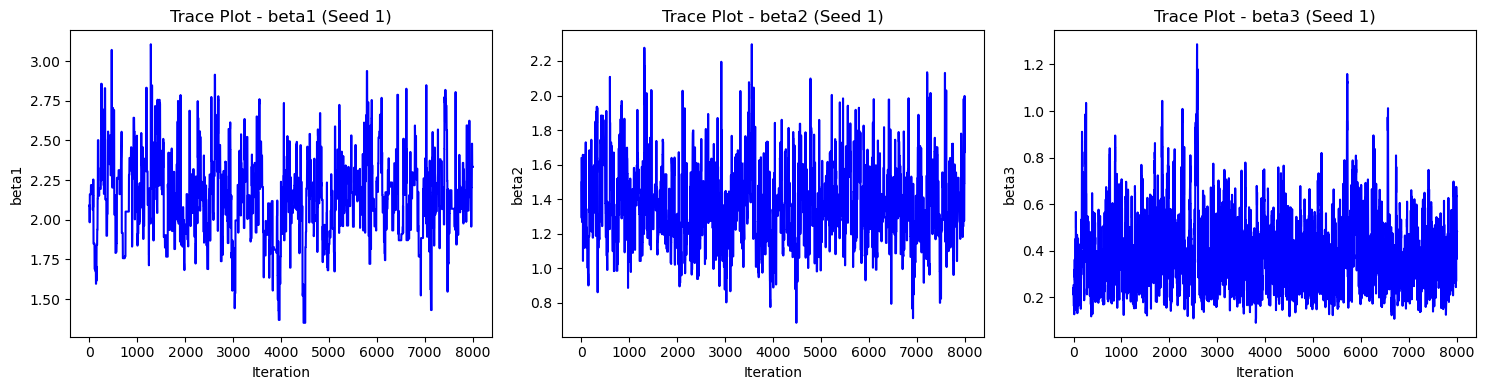

In [10]:
seed = 1
burnIn = 2000
param_names = ["beta1", "beta2", "beta3"]  # only the first three

# Load chain
chain = np.load(f"chain_seed_calibration_v6_1.npy")
post_chain = chain[burnIn:, :3]  # keep only first 3 columns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plt.subplots_adjust(wspace=0.4)

for ax, i, param in zip(axes, range(3), param_names):
    ax.plot(post_chain[:, i], 'b-', label="Chain values")
    ax.set_title(f"Trace Plot - {param} (Seed {seed})")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(param)

plt.tight_layout()
plt.savefig("Chain_Plots_Betas123.png", dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Load chain and compute medians
posterior_samples = np.load("chain_seed_calibration_v5_1.npy")[2001:]  # burn-in already applied
param_names = ["beta1", "beta2", "beta3", "lambda"]

posterior_medians = np.median(posterior_samples, axis=0)

# Assign fixed hyperparameters
beta_hat   = posterior_medians[:3]
lambda_hat = posterior_medians[3]

predict\_eta\_at\_field\_locations

### Input Setup
Field locations with current theta value:
\begin{equation}
\mathbf{x}^*_i = [x_{1i}, x_{2i}, \theta] \quad \text{for } i = 1, \ldots, n_{\text{field}}
\end{equation}

### Training Data Covariance Matrix
The $m \times m$ covariance matrix between training points:
\begin{equation}
\mathbf{K}_{ij} = \text{cov\_eta}(\mathbf{B}_i, \mathbf{B}_j, \boldsymbol{\beta}, \lambda)
\end{equation}

\begin{equation}
\mathbf{K}_{ij} = \frac{1}{\lambda} \exp\left(-\sum_{k=1}^{p} \beta_k |B_{ik} - B_{jk}|^\alpha - \sum_{k=1}^{L} \beta_{p+k} |B_{i,p+k} - B_{j,p+k}|^\alpha\right)
\end{equation}

where $p = 2$ (spatial dimensions), $L = 1$ (theta dimension), and $\alpha = 2$.

### Cross Covariance Matrix
The $n_{\text{field}} \times m$ cross-covariance between field locations and training points:
\begin{equation}
\mathbf{K}^*_{ij} = \text{cov\_eta}(\mathbf{x}^*_i, \mathbf{B}_j, \boldsymbol{\beta}, \lambda)
\end{equation}

\begin{equation}
\mathbf{K}^*_{ij} = \frac{1}{\lambda} \exp\left(-\sum_{k=1}^{p} \beta_k |x^*_{ik} - B_{jk}|^\alpha - \sum_{k=1}^{L} \beta_{p+k} |x^*_{i,p+k} - B_{j,p+k}|^\alpha\right)
\end{equation}

### Covariance at Field Locations
The $n_{\text{field}} \times n_{\text{field}}$ covariance between field locations:
\begin{equation}
\mathbf{K}^{**}_{ij} = \text{cov\_eta}(\mathbf{x}^*_i, \mathbf{x}^*_j, \boldsymbol{\beta}, \lambda)
\end{equation}

\begin{equation}
\mathbf{K}^{**}_{ij} = \frac{1}{\lambda} \exp\left(-\sum_{k=1}^{p} \beta_k |x^*_{ik} - x^*_{jk}|^\alpha - \sum_{k=1}^{L} \beta_{p+k} |x^*_{i,p+k} - x^*_{j,p+k}|^\alpha\right)
\end{equation}

### GP Prediction Mean
Training covariance inverse:
\begin{equation}
\mathbf{K}^{-1} = \mathbf{K}^{-1}
\end{equation}

Predicted mean at field locations:
\begin{equation}
\boldsymbol{\mu^*} = \mathbf{K}^* \mathbf{K}^{-1} \mathbf{y_{sim}}
\end{equation}

where $\mathbf{y_{sim}}=\mathbf{s\_eta}$ is the vector of standardized training outputs.

### GP Prediction Variance
Predicted covariance matrix:
\begin{equation}
\boldsymbol{\hat{\eta}_{cov}} = \mathbf{K}^{**} - \mathbf{K}^* \mathbf{K}^{-1} (\mathbf{K}^*)^T
\end{equation}

\begin{equation}
\hat{\eta} \sim \mathcal{GP}(\mu^*, \hat{\eta}_{cov})
\end{equation}

In [13]:
def predict_eta_at_field_locations(theta_val, x_field_std, beta_fixed, lambda_fixed):
    """
    Predict eta at field locations for a given theta 
    
    Parameters:
    - theta_val: current theta value
    - x_field_std: standardized field input locations (n x 2)
    - beta_fixed: fixed beta parameters [beta1, beta2, beta3]
    - lambda_fixed: fixed lambda parameter
    
    Returns:
    - eta_hat_mean: predicted mean at field locations
    - eta_hat_var: predicted variance at field locations
    """
    n_field = x_field_std.shape[0]
    
    # Create field input with theta (n x 3: x1, x2, theta)
    x_field_with_theta = np.column_stack([
        x_field_std[:, :2],  # x1, x2 from field locations
        np.full(n_field, theta_val)  # theta value for all locations
    ])
    
    # Simulation data covariance (using B matrix and functions)
    K_train = cov_mat_eta(B, beta_fixed, lambda_fixed)  # B is simulation input matrix
    
    # Cross covariance between field locations and training locations
    K_cross = np.zeros((n_field, m))  # m is number of simulation points
    for i in range(n_field):
        for j in range(m):
            K_cross[i, j] = cov_eta(x_field_with_theta[i, :], B[j, :], beta_fixed, lambda_fixed)
    
    # Self covariance at field locations
    K_field = np.zeros((n_field, n_field))
    for i in range(n_field):
        for j in range(n_field):
            K_field[i, j] = cov_eta(x_field_with_theta[i, :], x_field_with_theta[j, :], beta_fixed, lambda_fixed)
    
    # GP prediction 
    try:
        K_inv = solve(K_train, np.eye(K_train.shape[0]))
        eta_hat_mean = K_cross @ K_inv @ s_eta  # s_eta is standardized eta
        eta_hat_var = np.diag(K_field - K_cross @ K_inv @ K_cross.T)
        eta_hat_var = np.maximum(eta_hat_var, 1e-8)  # to ensure positive variance
        
        return eta_hat_mean, eta_hat_var
    except np.linalg.LinAlgError:
        return np.zeros(n_field), np.ones(n_field)

## log\_likelihood\_calibration


### Log Likelihood
Gaussian likelihood with (heteroscedastic) variance:


\begin{equation}
\log \mathcal{L}(\theta) 
= -\frac{n_{\text{field}}}{2} \log(2\pi) 
  - \frac{1}{2} \sum_{i=1}^{n_{\text{field}}} \log(\sigma^2_{i}) 
  - \frac{1}{2} (y - \eta(\theta))^\top (\Sigma)^{-1} (y - \eta(\theta)).
\end{equation}

This assumes:
\begin{equation}
y_{\text{field},i} | \theta \sim \mathcal{N}(\eta(\theta), \Sigma)
\end{equation}


where
$$
\eta(\theta) \sim \mathcal{N} (\mu^*, \Sigma^*)
\qquad 
\Sigma = \tfrac{1}{\lambda_\epsilon} I_n = \sigma^2 I_n 
$$

"""
The log-density is
$$ \log p\!\left(y \mid \eta(\theta), \Sigma\right) 
= -\tfrac{n}{2}\log(2\pi) 
  - \tfrac{1}{2}\log \big|\Sigma^*\big| 
  - \tfrac{1}{2}(y - \mu^*)^\top (\Sigma^*)^{-1} (y - \mu^*).$$

$$
\log \mathcal{L}(\theta) 
= -\frac{n}{2}\log(2\pi) 
  - \frac{1}{2}\sum_{i=1}^n \log \sigma_i^2
  - \frac{1}{2}\sum_{i=1}^n \frac{(y_i - \mu_i^*)^2}{\sigma_i^2},
$$
"""
where
$$
\sigma_i^2 =  \frac{1}{\lambda_\epsilon} = \sigma^2 = 0.25^2.
$$


## Function 3: log\_posterior\_calibration

### Prior Distribution
We already know Gaussian prior on theta:
\begin{equation}
\log \pi(\theta) = -\frac{1}{2}\left(\frac{\theta - \mu_{\text{prior}}}{\sigma_{\text{prior}}}\right)^2 - \log(\sqrt{2\pi} \sigma_{\text{prior}})
\end{equation}

Equivalently:
\begin{equation}
\theta \sim \mathcal{N}(\mu_{\text{prior}}, \sigma_{\text{prior}}^2)
\end{equation}


### Log Posterior
Combined prior and averaged likelihood:
\begin{equation}
\log \pi(\theta | \mathbf{y}_{\text{field}}) = \log \pi(\theta) + \log L(\theta) 
\end{equation}



## calibration\_mcmc

### Beta and Lambda Sample Construction
For each posterior sample $j$:
\begin{equation}
\boldsymbol{\beta}^{(j)} = [\beta_1^{(j)}, \beta_2^{(j)}, \beta_3^{(j)}]
\end{equation}

\begin{equation}
\boldsymbol{\lambda}^{(j)} = [\lambda^{(j)}]
\end{equation}

### Proposal Distribution
Random walk Metropolis proposal:
\begin{equation}
\theta^{\text{prop}} \sim \mathcal{N}(\theta^{\text{current}}, \sigma_{\text{proposal}}^2)
\end{equation}

### Metropolis-Hastings Acceptance
Log acceptance probability:
\begin{equation}
\log \alpha = \log \pi(\theta^{\text{prop}} | \mathbf{y}_{\text{field}}) - \log \pi(\theta^{\text{current}} | \mathbf{y}_{\text{field}})
\end{equation}

Acceptance probability:
\begin{equation}
\alpha = \min\left(1, \exp(\log \alpha)\right) = \min\left(1, \frac{\pi(\theta^{\text{prop}} | \mathbf{y}_{\text{field}})}{\pi(\theta^{\text{current}} | \mathbf{y}_{\text{field}})}\right)
\end{equation}

Accept proposal if:
\begin{equation}
\log(U) < \log \alpha
\end{equation}

where $U \sim \text{Uniform}(0,1)$.

### Posterior Distribution
The target posterior distribution is:
\begin{equation}
\pi(\theta | \mathbf{y}_{\text{field}}) \propto \mathcal{L}(\mathbf{y}_{\text{field}} | \theta) \pi(\theta)
\end{equation}

where the likelihood $\mathcal{L}(\mathbf{y}_{\text{field}} | \theta)$ is computed using the GP emulator trained on simulation data, and the calibration uses only field observations.


In [15]:
from numpy.random import multivariate_normal

def log_posterior_calibration(theta_val, y_field_std, x_field_std, beta_samples, lambda_samples, lambda_eps):
    """
    Log posterior for theta using sampled beta, lambda, and Version 1 (sampling μ*).
    """
    # Prior for theta
    log_prior = w1(theta_val)
    
    # Pick one by one posterior sample of (beta, lambda)
    #idx = iter_idx % len(beta_samples)
    idx = np.random.randint(len(beta_samples)) #and also remove the iter_idx if you prefer this
   
    #idx = iter_idx % len(beta_samples)
    beta_i = beta_samples[idx]
    lambda_i = lambda_samples[idx]
    
    # Emulator predictions at field locations
    eta_hat_mean, eta_hat_var = predict_eta_at_field_locations(theta_val, x_field_std, beta_i, lambda_i)

    # Covariance matrix Sigma* = {diag(var) +} (1/lambda_eps) I
    n_field = len(y_field_std)
    Sigma = np.diag(np.repeat(1.0 / lambda_eps, n_field)) #eta_hat_var + #np.diag(eta_hat_var + 1.0 / lambda_eps)
    
    try:
        # sample μ* ~ MVN(eta_hat_mean, cov_star) 
        cov_star = np.diag(eta_hat_var)
        mu_star = multivariate_normal(mean=eta_hat_mean, cov=cov_star)
        
        # Likelihood: y_field ~ MVN(mu_star, Sigma)
        log_lik = stats.multivariate_normal.logpdf(y_field_std, mean=mu_star, cov=Sigma)
    except np.linalg.LinAlgError:
        log_lik = -np.inf
    
    return log_prior + log_lik


In [16]:
def calibration_mcmc(posterior_samples, y_field_std, x_field_std, lambda_eps, 
                    iterations=10000, burnin=2000, proposal_sd=0.7):
    """
    MCMC for theta calibration
    
    Parameters:
    - posterior_samples: samples from first MCMC [theta, beta1, beta2, lambda]
    - y_field_std: standardized field observations
    - x_field_std: standardized field input locations
    - lambda_eps: measurement error precision
    - iterations: number of MCMC iterations
    - burnin: number of burnin iterations
    - proposal_sd: proposal standard deviation for theta
    
    Returns:
    - theta_chain: MCMC samples for theta (post-burnin)
    - acceptance_rate: acceptance rate
    """
    
    # Extract beta and lambda samples from posterior
    beta1_samples = posterior_samples[:, 0]  # beta1
    beta2_samples = posterior_samples[:, 1]  # beta2
    beta3_samples = posterior_samples[:, 2]   # beta3 
    lambda_samples = posterior_samples[:, 3]  # lambda
    
    # Combine beta samples
    beta_samples = [np.array([beta1_samples[i], beta2_samples[i], beta3_samples[i]]) 
                   for i in range(len(posterior_samples))]
    
    # Initialize chain
    theta_chain = np.zeros(iterations + 1)
    theta_chain[0] = 0.5  # Starting value
    
    n_accepted = 0
    
    print("Starting calibration MCMC...")
    
    for i in range(iterations):
        if (i + 1) % 1000 == 0:
            print(f"Iteration {i + 1}/{iterations}, Acceptance rate: {n_accepted/(i+1):.3f}")
        
        # Current theta
        theta_current = theta_chain[i]
        
        # Propose new theta
        theta_prop = np.random.normal(theta_current, proposal_sd)
        

        # Compute log posterior for current and proposed theta

        """
        log_post_current = log_posterior_calibration(
            theta_current, y_field_std, x_field_std,
            beta_samples, lambda_samples, lambda_eps, i
        )
    
        log_post_prop = log_posterior_calibration(
            theta_prop, y_field_std, x_field_std,
            beta_samples, lambda_samples, lambda_eps, i
        )
        """
        
        log_post_current = log_posterior_calibration(
            theta_current, y_field_std, x_field_std, beta_samples, lambda_samples, lambda_eps
        )
        
        log_post_prop = log_posterior_calibration(
            theta_prop, y_field_std, x_field_std, beta_samples, lambda_samples, lambda_eps
        )
        
        # Accept/reject step
        log_alpha = log_post_prop - log_post_current
        
        if np.isfinite(log_alpha) and np.log(np.random.rand()) < log_alpha:
            theta_chain[i + 1] = theta_prop
            n_accepted += 1
        else:
            theta_chain[i + 1] = theta_current
    
    acceptance_rate = n_accepted / iterations
    print(f"Final acceptance rate: {acceptance_rate:.3f}")

    np.save(f"theta_samples_case3.npy", theta_chain[burnin + 1:])
    
    # Return post-burnin samples
    return theta_chain[burnin + 1:], acceptance_rate

    print("saved")


In [19]:
# Prepare field data (standardize field inputs in the same way as simulation data)
x_field_std = np.column_stack([
    (x_field[:, 0] - np.min(x_field[:, 0])) / (np.max(x_field[:, 0]) - np.min(x_field[:, 0])),
    (x_field[:, 1] - np.min(x_field[:, 1])) / (np.max(x_field[:, 1]) - np.min(x_field[:, 1]))
])

# Standardize field outputs in the same way as eta
y_field_std = (y_field - np.mean(y_field)) / np.std(y_field)

# Run calibration MCMC (only theta is sampled, beta and lambda sampled from posterior)
theta_samples_case3, acc_rate = calibration_mcmc(
    posterior_samples, y_field_std, x_field_std, 
    lambda_eps=true_lambda_eps, 
    iterations=10000, burnin=2000
)

# Results
print(f"True theta: {true_theta}")
print(f"Posterior mean: {np.mean(theta_samples_case3):.4f}")
print(f"Posterior std: {np.std(theta_samples_case3):.4f}")
print(f"95% CI: [{np.percentile(theta_samples_case3, 2.5):.4f}, {np.percentile(theta_samples_case3, 97.5):.4f}]")


Starting calibration MCMC...
Iteration 1000/10000, Acceptance rate: 0.446
Iteration 2000/10000, Acceptance rate: 0.430
Iteration 3000/10000, Acceptance rate: 0.429
Iteration 4000/10000, Acceptance rate: 0.427
Iteration 5000/10000, Acceptance rate: 0.430
Iteration 6000/10000, Acceptance rate: 0.427
Iteration 7000/10000, Acceptance rate: 0.423
Iteration 8000/10000, Acceptance rate: 0.422
Iteration 9000/10000, Acceptance rate: 0.425
Iteration 10000/10000, Acceptance rate: 0.423
Final acceptance rate: 0.423
True theta: 0.5
Posterior mean: 0.3098
Posterior std: 0.4809
95% CI: [-0.6485, 1.1724]


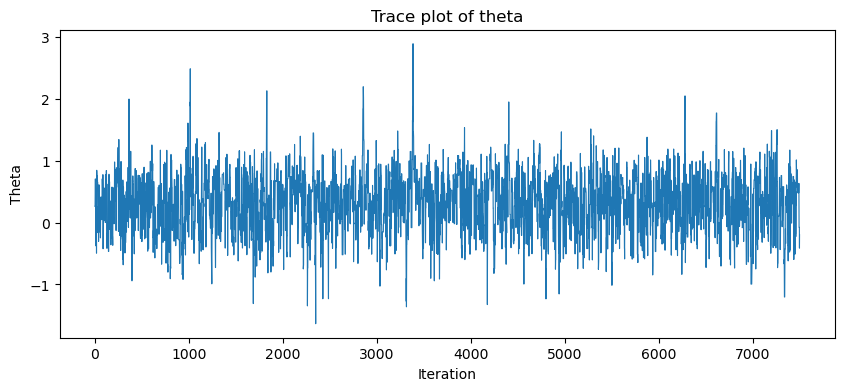

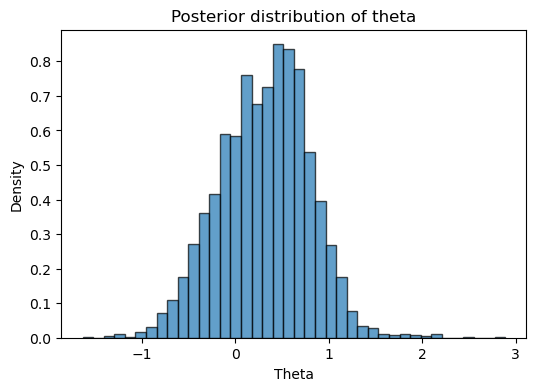


Effective Sample Size (ESS):
<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.052e+03


In [20]:
import matplotlib.pyplot as plt
import arviz as az

# === Trace plot ===
plt.figure(figsize=(10,4))
plt.plot(theta_samples_case3[500:], lw=0.8)
plt.title("Trace plot of theta")
plt.xlabel("Iteration")
plt.ylabel("Theta")
plt.show()

# === Posterior histogram ===
plt.figure(figsize=(6,4))
plt.hist(theta_samples_case3, bins=40, density=True, alpha=0.7, edgecolor="k")
plt.title("Posterior distribution of theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.show()

# === Effective Sample Size (ESS) ===
idata = az.convert_to_inference_data(theta_samples_case3)
ess = az.ess(idata)
print("\nEffective Sample Size (ESS):")
print(ess)

<Figure size 800x400 with 0 Axes>

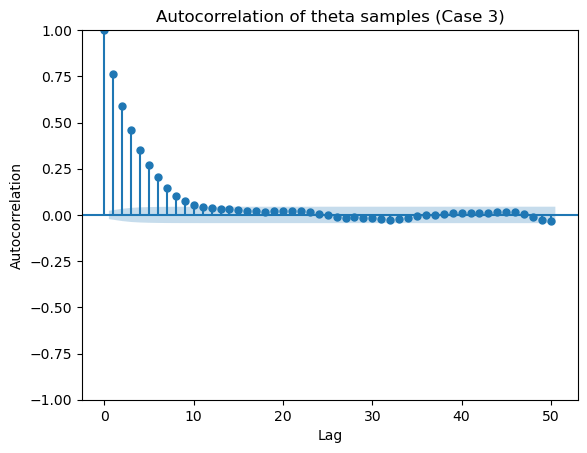

In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation for theta samples
plt.figure(figsize=(8, 4))
plot_acf(theta_samples_case3[500:], lags=50)  # You can change lags if needed
plt.title("Autocorrelation of theta samples (Case 3)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()


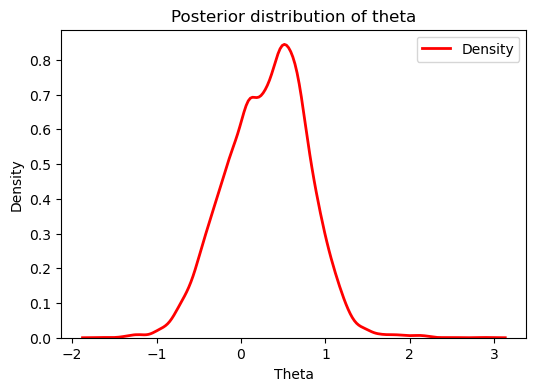

In [22]:

plt.figure(figsize=(6,4))
#sns.histplot(theta_samples, bins=40, stat="density", alpha=0.6, edgecolor="k", label="Histogram")
sns.kdeplot(theta_samples_case3[500:], color="red", lw=2, label="Density")
plt.title("Posterior distribution of theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

In [23]:
theta_samples_v1 = np.load("theta_samples_case1.npy")
theta_samples_v2 = np.load("theta_samples_case2.npy")
theta_samples_v3 = np.load("theta_samples_case3.npy")


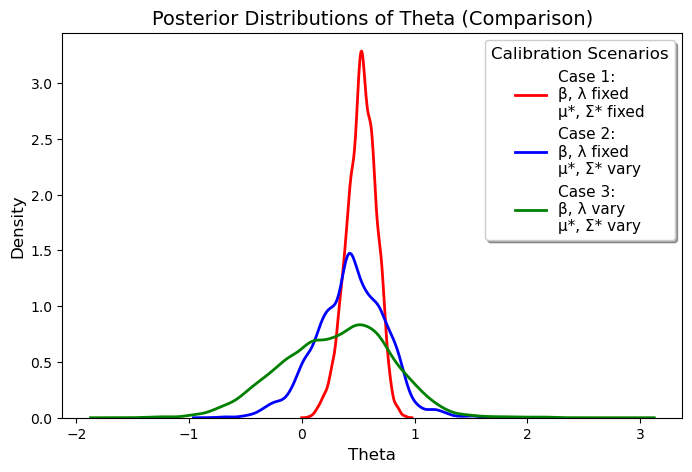

In [24]:
plt.figure(figsize=(8,5))

sns.kdeplot(theta_samples_v1, color="red", lw=2, label="Case 1:\nβ, λ fixed\nμ*, Σ* fixed")
sns.kdeplot(theta_samples_v2, color="blue", lw=2, label="Case 2:\nβ, λ fixed\nμ*, Σ* vary")
sns.kdeplot(theta_samples_v3, color="green", lw=2, label="Case 3:\nβ, λ vary\nμ*, Σ* vary")

plt.title("Posterior Distributions of Theta (Comparison)", fontsize=14)
plt.xlabel("Theta", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.legend(
    title="Calibration Scenarios", 
    title_fontsize=12, 
    fontsize=11,
    frameon=True, 
    fancybox=True, 
    shadow=True, 
    loc="best"
)

plt.show()


In [25]:
beta1_samples = posterior_samples[:, 0]  # beta1
beta2_samples = posterior_samples[:, 1]  # beta2
beta3_samples = posterior_samples[:, 2]   # beta3 
lambda_samples = posterior_samples[:, 3]  # lambda
    
# Combine beta samples
beta_samples = [np.array([beta1_samples[i], beta2_samples[i], beta3_samples[i]]) 
                   for i in range(len(posterior_samples))]

8000


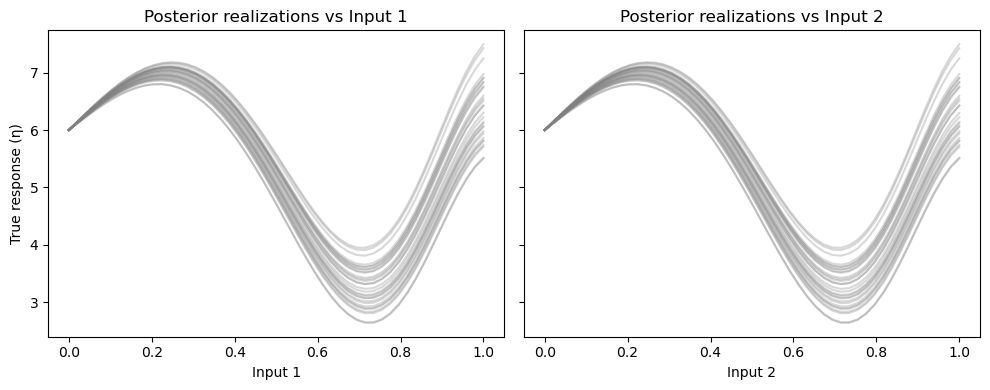

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Input grid
x1 = np.linspace(0, 1, 50)   # first input
x2 = np.linspace(0, 1, 50)   # second input
grid = np.column_stack([x1, x2])  # shape (50, 2)

# Posterior draws
print(len(theta_samples_case3))
posterior_draws = theta_samples_case3[::100]

def true_response(x, theta):
    return (4
            + np.sin(2 * np.pi * x[:, 0])
            + np.exp(theta * x[:, 1])
            + np.cos(2 * np.pi * x[:, 0] * x[:, 1]))

# Number of panels = number of input dimensions
n_panels = grid.shape[1]
fig, axes = plt.subplots(1, n_panels, figsize=(5*n_panels, 4), sharey=True)

for j in range(n_panels):
    ax = axes[j]

    # Loop over posterior draws
    for theta in posterior_draws[:30]:   # plot 30 realizations
        y_true = true_response(grid, theta)  # true simulator response

        ax.plot(grid[:, j], y_true, alpha=0.3, color="gray")

    ax.set_title(f"Posterior realizations vs Input {j+1}")
    ax.set_xlabel(f"Input {j+1}")
    if j == 0:
        ax.set_ylabel("True response (η)")

plt.tight_layout()
plt.show()
